#Audio  To text AI Application

In [3]:
import keras
from keras.models import Model
from keras.layers import Input, LSTM, Dense, TimeDistributed

In [4]:
!pip install jiwer

In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from IPython import display
from jiwer import wer

https://www.kaggle.com/datasets/awsaf49/ljspeech-sr16k-dataset/code

In [6]:
data_url = "https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2"
data_path =  keras.utils.get_file("LJSpeech-1.1", data_url , untar=True)

In [7]:
wavs_path = data_path + "/wavs/"
metadata_path = data_path + "/metadata.csv"

* Read metadata file and parse it





In [8]:
metadata_df = pd.read_csv(metadata_path , sep="|" , header=None , quoting=3)

 * Visualisation :

In [9]:
metadata_df.columns = ["file_name" , "transcription", "normalized_transcription"]
metadata_df = metadata_df[["file_name" , "normalized_transcription"]]
metadata_df = metadata_df.sample(frac=1).reset_index(drop=True)


In [10]:
metadata_df.head()

,file_name,normalized_transcription
0,LJ048-0132,which would bring to bear the judgment and exp...
1,LJ012-0109,"But they at once made tracks, and took up thei..."
2,LJ049-0230,can and should be recommended by this Commissi...
3,LJ038-0288,The admissions made to Marina Oswald by her hu...
4,LJ043-0132,He subsequently found a job with the Texas Sch...


In [11]:
metadata_df.tail()

,file_name,normalized_transcription
13095,LJ028-0218,"Without a skirmish or a battle, he permitted t..."
13096,LJ001-0026,On the whole the type of this book may be cons...
13097,LJ046-0111,The Secret Service has attempted to perform th...
13098,LJ003-0033,"Enough has been said, probably, to prove that ..."
13099,LJ019-0155,The enforcement of discipline depended upon th...


* Split data into training and validation data

In [12]:
split = int(len(metadata_df)*0.9)
df_train = metadata_df[:split]
df_val = metadata_df[:split]

print( "Size of the training set : {}".format( len(df_train) ))
print( "Size of the training set : {}".format( len(df_val) ))

Size of the training set : 11790
Size of the training set : 11790


#Preprocessing

* prepare the vocab to be used  :

In [13]:
# the set of characters accepted in the transciprtion
charachters = [ x for x in "abcdefghijklmnopqrstuvwxyz'?! "]
#Mapping charchaters to integers
char_to_num = keras.layers.StringLookup(vocabulary=charachters ,  oov_token="" )
#Mapping integers back to original charchaters
num_to_char = keras.layers.StringLookup( vocabulary = char_to_num.get_vocabulary() ,
                                        oov_token="", invert=True )

print(
    f"The vocabulary is : { char_to_num.get_vocabulary()}\n"
    f"(size ={ char_to_num.vocabulary_size() })"
)


The vocabulary is : ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', ' ']
(size =31)


In [14]:
char_to_num

In [15]:
#An integer scalar Tensor . The window length in samples
frame_length= 256
#An integer scalar Tensor . The size of samples to steps
frame_step = 160
#An integer scalar Tensor . The size of the FFt to aply
#If not privided n uses the samllest power of 2 enclosing frame_length.
fft_length = 384

In [16]:
def encode_single_sample(wav_file, label):
  # proces the audio

  #Read waf file :
  file = tf.io.read_file(wavs_path + wav_file+ ".wav")
  #Decode the wav file
  audio,_ = tf.audio.decode_wav(file)
  audio = tf.squeeze(audio, axis= 1)
  # Change type to float
  audio = tf.cast(audio , tf.float32)
  # Get the spectrogram
  spectrogram = tf.signal.stft(audio , frame_length=frame_length , frame_step=frame_step , fft_length=fft_length )
  # we onlu need the magnitude , which can be derived by applying tf.abs
  spectrogram  =tf.abs(spectrogram)
  spectrogram = tf.math.pow(spectrogram, 0.5)
  #normalisation
  means = tf.math.reduce_mean(spectrogram , 1, keepdims=True)
  stddevs = tf.math.reduce_std(spectrogram , 1, keepdims=True)
  spectrogram = (spectrogram - means) / (stddevs + 1e-10 )

  # Process the label
  #convert label to lower case
  label = tf.strings.lower(label)
  #split the label
  label = tf.strings.unicode_split(label , input_encoding="UTF-8")
  # map the characters in label to numbers
  label = char_to_num(label)
  # Return a dict as our model is expecting two inputs
  return spectrogram, label


In [17]:
#Create dataset objects

batch_size = 32
# Define the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices(
    ( list(df_train["file_name"]), list(df_train["normalized_transcription"]) )
)

train_dataset = (
    train_dataset.map(encode_single_sample , num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

#Define the validation dataset
validation_dataset = tf.data.Dataset.from_tensor_slices(
    ( list(df_val['file_name']), list(df_val['normalized_transcription']) )
)

validation_dataset = (
    validation_dataset.map(encode_single_sample , num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

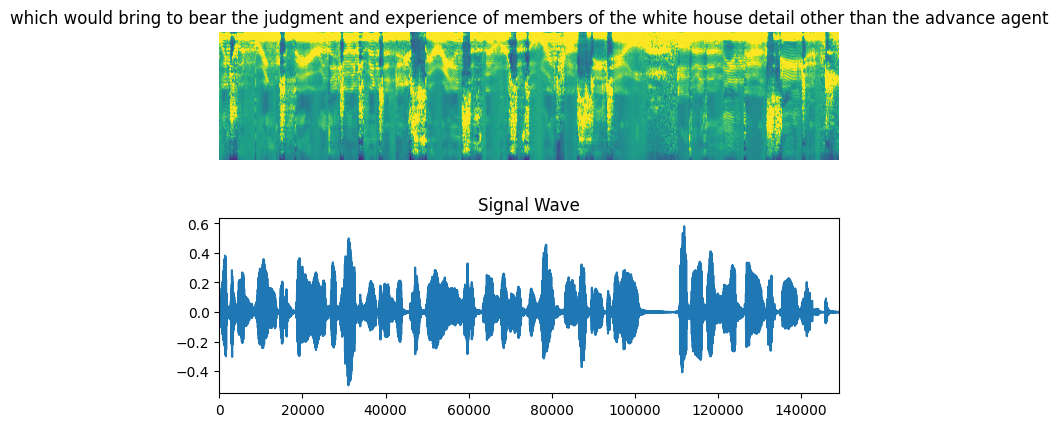

In [18]:
# visualize the data :

fig = plt.figure(figsize=(8,5))
for batch in train_dataset.take(1):
    spectrogram = batch[0][0].numpy()
    spectrogram = np.array([np.trim_zeros(x) for x in np.transpose(spectrogram)])
    label = batch[1][0]
    # Spectrogram
    label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
    ax= plt.subplot(2,1,1)
    ax.imshow(spectrogram, vmax=1)
    ax.set_title(label)
    ax.axis("off")
    # Wav
    file = tf.io.read_file(wavs_path + list( df_train["file_name"])[0]+".wav" )
    audio,_ = tf.audio.decode_wav(file)
    audio = audio.numpy()
    ax = plt.subplot(2,1,2)
    plt.plot(audio)
    ax.set_title("Signal Wave")
    ax.set_xlim(0 , len(audio))
    display.display(display.Audio(np.transpose(audio), rate=16000 ))
plt.show()

# Model

In [19]:
def CTCLoss(y_true, y_pred):
  #copute the training-time loss value
  batch_len = tf.cast(tf.shape(y_true)[0] , dtype="int64")
  input_length = tf.cast(tf.shape(y_pred)[1] , dtype="int64")
  label_length = tf.cast(tf.shape(y_true)[1] , dtype="int64")

  input_length = input_length *tf.ones(shape=(batch_len,1) , dtype="int64")
  label_length = label_length * tf.ones(shape=(batch_len,1), dtype="int64")

  loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length , label_length)
  return loss

In [20]:
def build_model(input_dim, output_dim, rnn_layers=5, rnn_units=128):
    # Model's input
    input_spectrogram = layers.Input((None, input_dim), name="input")
    # Expand the dimension to use 2D CNN
    x = layers.Reshape((-1, input_dim, 1), name="expand_dim")(input_spectrogram)
    # Convolution layer 1
    x = layers.Conv2D(
        filters=32,  # Corrected parameter name
        kernel_size=[11, 41],
        strides=[2, 2],
        padding="same",
        use_bias=False,
        name="conv_1",
    )(x)
    x = layers.BatchNormalization(name="conv_1_bn")(x)  # Updated batch normalization name
    x = layers.ReLU(name="conv_1_relu")(x)
    # Reshape the resulted volume to feed the RNNs layers
    x = layers.Reshape((-1, x.shape[-2] * x.shape[-1]))(x)
    # RNN layers
    for i in range(1, rnn_layers + 1):
        recurrent = layers.GRU(
            units=rnn_units,
            activation="tanh",
            recurrent_activation="sigmoid",
            use_bias=True,
            return_sequences=True,
            reset_after=True,
            name=f"gru_{i}",
        )
        if i < rnn_layers:
            x = layers.Dropout(rate=0.5)(x)
    # Dense layer
    x = layers.Dense(units=rnn_units * 2, name="dense_1")(x)
    x = layers.ReLU(name="dense_1_relu")(x)
    x = layers.Dropout(rate=0.5)(x)
    # Classification layer
    output = layers.Dense(units=output_dim + 1, activation="softmax")(x)
    # Model
    model = keras.Model(input_spectrogram, output, name="DeepSpeech_2")
    # Optimizer
    opt = keras.optimizers.Adam(learning_rate=1e-4)
    # Compile the model and return
    model.compile(optimizer=opt, loss=CTCLoss)  # Corrected optimizer parameter name
    return model


In [21]:
# Get the model
model = build_model(
    input_dim=fft_length // 2 + 1,
    output_dim=char_to_num.vocabulary_size()+1,
    rnn_units=512,
)
model.summary(line_length=110)

Model: "DeepSpeech_2"
______________________________________________________________________________________________________________
 Layer (type)                                    Output Shape                                Param #          
 input (InputLayer)                              [(None, None, 193)]                         0                
                                                                                                              
 expand_dim (Reshape)                            (None, None, 193, 1)                        0                
                                                                                                              
 conv_1 (Conv2D)                                 (None, None, 97, 32)                        14432            
                                                                                                              
 conv_1_bn (BatchNormalization)                  (None, None, 97, 32)                     

# Training and Evaluating

In [24]:
# A utility function to decode the output of th network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    # Iterate over the results and get back the text
    output_text = []
    for result in results:
        result = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
        output_text.append(result)
    return output_text



# A callback to output a few transcriptions during training
class CallbackEval(keras.callbacks.Callback):

  def __init__(self,dataset):
    super().__init__()
    self.dataset= dataset

  def on_epoch_end(self,epoch:int , logs=None ) :
    predictions=[]
    targets=[]
    for batch in self.dataset :
      x,y = batch
      batch_predictions = model.predict(x)
      batch_predictions = decode_batch_predictions(batch_predictions)
      predictions.extend(batch_predictions)
      for label in y :
        label = (
            tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        )
        targets.append(label)
      wer_score = wer(targets, predictions)
      print("-"*100)
      print(f"word Error Rate : {wer_score:.4f}")
      print("-"*100)
      for i in np.random.randint(0, len(predictions),2):
        print(f"Target   :{targets[1]}")
        print(f"Prediction : {predictions[i]}")
        print("-"*100)

In [25]:
#train

#define the number of epochs
epochs =2
#Callback function to check transcirption on the val set.
validation_callback = CallbackEval(validation_dataset)
#train the model
history = model.fit(
    train_dataset,
    validation_data = validation_dataset,
    epochs=epochs,
    callbacks=[validation_callback],
)


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
----------------------------------------------------------------------------------------------------
Target   :but they at once made tracks and took up their residence under assumed names in a tavern in bloomsbury
Prediction : 
----------------------------------------------------------------------------------------------------
Target   :but they at once made tracks and took up their residence under assumed names in a tavern in bloomsbury
Prediction : 
----------------------------------------------------------------------------------------------------
1/1 [==============================] - 0s 158ms/step
----------------------------------------------------------------------------------------------------
word Error Rate : 1.0000
----------------------------------------------------------------------------------------------------
Target   :but they at once made tracks and took up their residence under assumed name

In [26]:
# test
predictions=[]
targets=[]
for batch in validation_dataset :
  X,y = batch
  batch_predictions = model.predict(X)
  batch_predictions = decode_batch_predictions(batch_predictions)
  predictions.extend(batch_predictions)
  for label in y :
    label = (
        tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
    )
    targets.append(label)
wer_score = wer(targets, predictions)
print("-"*100)
print(f"word Error Rate : {wer_score:.4f}")
print("-"*100)
for i in np.random.randint(0, len(predictions),2):
  print(f"Target   :{targets[1]}")
  print(f"Prediction : {predictions[i]}")
  print("-"*100)

1/1 [==============================] - 0s 58ms/step
----------------------------------------------------------------------------------------------------
word Error Rate : 1.0000
----------------------------------------------------------------------------------------------------
Target   :but they at once made tracks and took up their residence under assumed names in a tavern in bloomsbury
Prediction : l
----------------------------------------------------------------------------------------------------
Target   :but they at once made tracks and took up their residence under assumed names in a tavern in bloomsbury
Prediction : l
----------------------------------------------------------------------------------------------------


In [27]:
# Save the model
model.save('my_model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
